# Определение перспективного тарифа для телеком-компании

## Описание проекта

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Обзор файла с данными и общая информация

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [68]:
import warnings

warnings.filterwarnings("ignore")

In [69]:
calls = pd.read_csv('/datasets/calls.csv')

In [70]:
internet = pd.read_csv('/datasets/internet.csv')

In [71]:
messages = pd.read_csv('/datasets/messages.csv')

In [72]:
tariffes = pd.read_csv('/datasets/tariffs.csv')

In [73]:
users = pd.read_csv('/datasets/users.csv')

In [74]:
calls.info()
internet.info()
messages.info()
tariffes.info()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 co

In [75]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [76]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [77]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [78]:
tariffes.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [79]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


В датасетах даты заполнены в неверном формате (object). Заменим на формат даты.

In [80]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [81]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [82]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [83]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [84]:
users.columns=['user_id','age','churn_date', 'city', 'first_name', 
               'last_name', 'reg_date', 'tariff_name'] 
# заменила название столбца с тарифом для сопоставимости данных

In [85]:
calls.duplicated().sum()
internet.duplicated().sum()
messages.duplicated().sum()
tariffes.duplicated().sum()
users.duplicated().sum()

0

Дублиикатов в исходных данных нет.

In [86]:
calls['duration'] = calls['duration'].apply(pd.np.ceil) #округление до целого

In [87]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month 
# Добавление столбцов с месяцем в датафрейм

In [88]:
calls.info()
internet.info()
messages.info()
tariffes.info()
users.info() #проверка результата

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
 5   m

<AxesSubplot:>

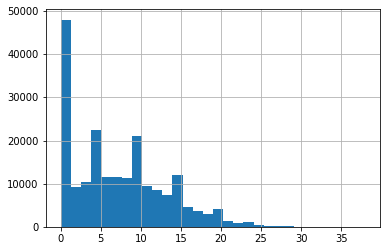

In [89]:
calls['duration'].hist(bins=30)

In [90]:
calls.query('0 < duration < 1')

,id,call_date,duration,user_id,month


<AxesSubplot:>

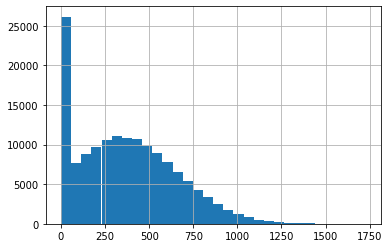

In [91]:
internet['mb_used'].hist(bins=30)

In [92]:
internet.query('0 < mb_used < 0.01')

,Unnamed: 0,id,mb_used,session_date,user_id,month


**Вывод:** Данные хорошие. пропусков не было, дубликатов не было. Для удобства работы были изменены наименования столбцов и изменены формат столбцов с датой. На гистограммах видно что большинство значений близки к 0, но нулевых значений в данных нет. Аномально  высоких значений в данных нет.

## Агрегация данных

Необходимо посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Необходимо собрать сводные таблицы по абоненту и месяцу для звонков, сообщений и трафика. Далее объединим в единый датафрейм для дальнейшего анализа.

In [93]:
df_calls = calls.pivot_table(
    index=['user_id', 'month'], 
    values='duration',
    aggfunc=['count', 'sum']).reset_index()

In [94]:
df_messages = messages.pivot_table(
    index=['user_id', 'month'], 
    values='id', 
    aggfunc='count').reset_index()

In [95]:
df_internet = internet.pivot_table(
    index=['user_id', 'month'], 
    values='mb_used', 
    aggfunc='sum').reset_index()

In [96]:
df = df_calls.merge(df_messages, 
                    on=['user_id', 'month'], 
                    how='outer').merge(df_internet, 
                                        on=['user_id', 'month'], 
                                        how='outer')

In [97]:
df = df.merge(users, on='user_id', how='left')

In [98]:
df = df.drop(columns=['age', 'churn_date', 'first_name', 'last_name'], axis=1) 
# отбросим лишние столбцы

In [99]:
df.head()

,user_id,month,"(user_id, )","(month, )","(count, duration)","(sum, duration)",id,mb_used,city,reg_date,tariff_name
0,1000,5,1000.0,5.0,22.0,159.0,22.0,2253.49,Краснодар,2018-05-25,ultra
1,1000,6,1000.0,6.0,43.0,172.0,60.0,23233.77,Краснодар,2018-05-25,ultra
2,1000,7,1000.0,7.0,47.0,340.0,75.0,14003.64,Краснодар,2018-05-25,ultra
3,1000,8,1000.0,8.0,52.0,408.0,81.0,14055.93,Краснодар,2018-05-25,ultra
4,1000,9,1000.0,9.0,58.0,466.0,57.0,14568.91,Краснодар,2018-05-25,ultra


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            3214 non-null   int64         
 1   month              3214 non-null   int64         
 2   (user_id, )        3174 non-null   float64       
 3   (month, )          3174 non-null   float64       
 4   (count, duration)  3174 non-null   float64       
 5   (sum, duration)    3174 non-null   float64       
 6   id                 2717 non-null   float64       
 7   mb_used            3203 non-null   float64       
 8   city               3214 non-null   object        
 9   reg_date           3214 non-null   datetime64[ns]
 10  tariff_name        3214 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 301.3+ KB


In [101]:
df = df.merge(tariffes, on='tariff_name', how='left')

In [102]:
df.columns = ['user_id', 'month', 'user_id2', 'month2', 'count_calls', 'dur_calls',
             'messages', 'mb_used', 'city', 'reg_date', 'tariff_name', 'messages_included',
             'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb',
             'rub_per_message', 'rub_per_minute'] # переименование столбцов

In [103]:
df = df.drop(columns=['user_id2', 'month2'], axis=1)

При объединении таблиц в колонках с длительностью звонков, количеством СМС и мегабайт появились пустые значения. это связано с тем, что клиент мог совершать звонки, но е использовать интернет или СМС, или же наоборот. Пустые значения лучше всего заполнить нулями.

In [104]:
df['dur_calls'] = df['dur_calls'].fillna(0) # fill NA

In [105]:
df['messages'] = df['messages'].fillna(0) # fill NA

In [106]:
df['mb_used'] = df['mb_used'].fillna(0) # fill NA

Далее рассчитываем количество платных звонков, смс и интернет-трафика. Для этого вычитаем из лимитного количества исрасходованное. Если сумма положительная, зачит лимит не был превышен, соответственно в столбце с плантым количеством укаываем "0". По отрицательным суммам посчитаем выручку.

In [107]:
df['pay_calls'] = df['minutes_included'] - df['dur_calls']

In [108]:
df['pay_messages'] = df['messages_included'] - df['messages']

In [109]:
df['pay_internet'] = df['mb_per_month_included'] - df['mb_used']

In [110]:
df.loc[df.pay_calls>0, 'pay_calls'] = 0

In [111]:
df.loc[df.pay_messages>0, 'pay_messages'] = 0

In [112]:
df.loc[df.pay_internet>0, 'pay_internet'] = 0

In [113]:
df['revenue'] = (
    (abs(df.pay_calls) * df.rub_per_minute) + 
    (abs(df.pay_messages) * df.rub_per_message) +
    ((abs(df.pay_internet)/1000).apply(pd.np.ceil) * df.rub_per_gb)) + df.rub_monthly_fee

In [114]:
display(df.isna().sum())

user_id                   0
month                     0
count_calls              40
dur_calls                 0
messages                  0
mb_used                   0
city                      0
reg_date                  0
tariff_name               0
messages_included         0
mb_per_month_included     0
minutes_included          0
rub_monthly_fee           0
rub_per_gb                0
rub_per_message           0
rub_per_minute            0
pay_calls                 0
pay_messages              0
pay_internet              0
revenue                   0
dtype: int64

## Анализ данных

Необходимо проанализировать сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

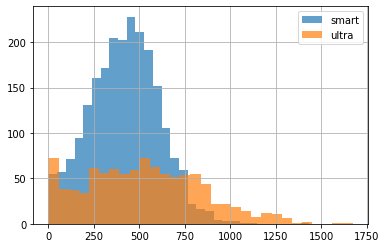

In [115]:
df.query('tariff_name == "smart"')['dur_calls'].hist(bins=30, alpha=.7, label='smart')
df.query('tariff_name == "ultra"')['dur_calls'].hist(bins=30, alpha=.7, label='ultra')
plt.legend()
plt.show()

Гистограмма длительности звонков на тарифе Смарт имеет нормальное распределение. Среднее в районе 450 мин. Гистограмма тарифа Ультра имеет средее значение в районе 500-550. При этом примерно равное количество абонентов совершают звонки от 250 до 750 мин. Также очень много нулевых значений. Возможно что многие абоненты не используют этот тариф для звонков.  

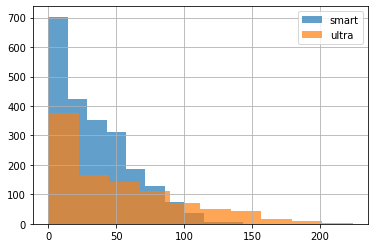

In [116]:
df.query('tariff_name == "smart"')['messages'].hist(bins=10, alpha=.7, label='smart')
df.query('tariff_name == "ultra"')['messages'].hist(bins=10, alpha=.7, label='ultra')
plt.legend()
plt.show()

На гистограмме отправленных сообщений для обоих тарифов видно что очень много значений около 0. Возможно абоненты редко пользуются этой услугой.

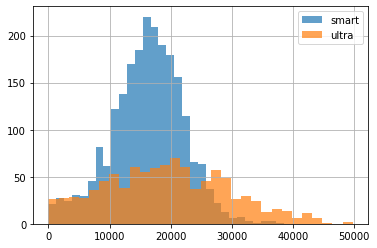

In [117]:
df.query('tariff_name == "smart"')['mb_used'].hist(bins=30, alpha=.7, label='smart')
df.query('tariff_name == "ultra"')['mb_used'].hist(bins=30, alpha=.7, label='ultra')
plt.legend()
plt.show()

Гистограммы использованного интернет-трафика для обоих тарифов имеют нормальное распределение. Среднее значение для тарифа Смарт - 15 тыс mb, для тарифа Ультра - 2 тыс mb. Пользователи тарифа Ультра используют больше интернет-трафика.  

In [118]:
df.pivot_table(
index='tariff_name',
values=['dur_calls', 'messages', 'mb_used'],
aggfunc=['mean', 'var', 'std'])

mean                                     var                \
              dur_calls       mb_used   messages      dur_calls       mb_used   
tariff_name                                                                     
smart        417.934948  16208.386990  33.384029   36219.315784  3.446250e+07   
ultra        526.623350  19468.805208  49.363452  100873.633397  1.017510e+08   

                                 std                           
                messages   dur_calls       mb_used   messages  
tariff_name                                                    
smart         796.812958  190.313730   5870.476681  28.227876  
ultra        2285.266143  317.606098  10087.170752  47.804457

Пользователи на тарифе Ultra в среднем используют больше звонков, смс, и интернет-трафика. При этом на тарифе Smart стандартное отклонение ниже,что говорит о том, что вырчка на тарифе Smart более устойчива.

## Проверка гиппотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформируем нулевую гиппотезу как:
- средняя выручка пользователей на тарифе Смарт равна выручке на тарифе Ультра
- средняя выручка в Москве равна средней выручке в остальных регионах.

Альтернативная гиппотеза:
- средняя выручка на тарифе Смарт не равна средней выручке на тарифе Ультра
- средняя выручка в Москве не равна средней выручке в остальных регионах

In [119]:
df_smart = df.query('tariff_name == "smart"')

In [120]:
df_ultra = df.query('tariff_name == "ultra"')

In [121]:
df_moscow = df.query('city == "Москва"')

In [122]:
df_other = df.query('city != "Москва"')

In [123]:
alpha = 0.05

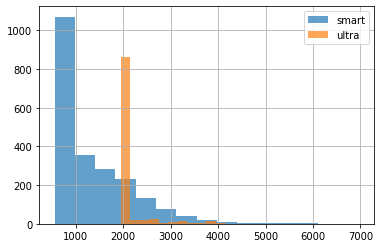

In [124]:
df_smart['revenue'].hist(bins=15, alpha=0.7, label='smart')
df_ultra['revenue'].hist(bins=15, alpha=.7, label='ultra')
plt.legend()
plt.show()

На гистограмме видно что больше всего значений имеет минимальное значене выручки. Например для тарифа Смарт - это 500-1000, для тарифа Ультра - 2000. Абонентская плата тарифа Смарт - 550 руб, Ультра - 1950. Соответственно большинство абонентов укладываются в ежемесячные лимиты и платят только абонентскую плату.

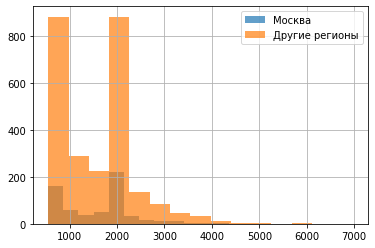

In [125]:
df_moscow['revenue'].hist(bins=15, alpha=0.7, label='Москва')
df_other['revenue'].hist(bins=15, alpha=0.7, label='Другие регионы')
plt.legend()
plt.show()

Гистограмма выручки абонентов Москвы и других регионов не отличаются между собой. Мы видим пики на значениях 550-1000 и 2000, что такж соответсвует сумме абонентской платы для обоих тарифов. Различия только в количестве абонентов. 

In [126]:
h0_tariff = st.ttest_ind(df_smart.revenue, df_ultra.revenue)

In [127]:
h0_region = st.ttest_ind(df_moscow.revenue, df_other.revenue)

In [128]:
display(h0_tariff)

Ttest_indResult(statistic=-27.690529741074982, pvalue=1.553031575858775e-151)

In [129]:
display(h0_region)

Ttest_indResult(statistic=0.5352966851453295, pvalue=0.5924817760011163)

In [130]:
df.pivot_table(index='tariff_name', values='revenue', aggfunc=['mean', 'var', 'std'])

,mean,var,std
,revenue,revenue,revenue
tariff_name,,,
smart,1303.253028,694546.611891,833.394632
ultra,2072.436548,147981.862078,384.684107


Гиппотеза о том что выручка на тарифе Смарт и Ультра одинаковая не подтвердилась. p-value 1.55е-151. Значение близко к 0. Это значит что вероятность получить значение равной выручки близко к 0. Гистограмма также подтвержает что средняя выручка на обоих тарифах отличается.
Гиппотеза о том что выручка в г. Москва равна выручке в других регионах подтверждается на 59%. P-value - 0.59. На гистограмме также видны пики и спады на одинаковых значениях выручки. Это также подтверждается гистограммами длительости звонков, количества сообщений и испльзованного интернет-трафика.   

## Выводы

Проведен анализ тарифов Smart и Ultra для компании  ООО"Мегалайн" с целью определения более выгоднного тарифа. Анализ проведен на основе данных за 2018 год: длительность звонков, количество СМС и использованных мегабайт. 
При первичной проверке не было выявлено выбросов данных. Для анализа все датафреймы были сгруппированы по абоненту и месяцу. Длительность звонков была округлена до целого числа по праилам тарификации. Мегабайты переведены в гигабайты. После этого данные были объединены в общий датафрейм и рассчитана ежемесячная выручка по каждому абоненту.
Для анализа рассчитаны среднее, дисперся и стандартное отклонение длительности звонков, количества СМС и мегабайт интернет-трафика. Анализ показал, что в среднем пользователи тарифа Ultra используют больше минут звонков, количества СМС и мегабайт трафика. Но при этом у пользователей тарифа Smart страндартное отклонение ниже. Это означает что показатели более стабильны.
Далее выдвинули 2 гиппотезы. 

Нулевая иппотеза:
- средняя выручка пользователей на тарифе Смарт равна выручке на тарифе Ультра
- средняя выручка в Москве равна средней выручке в остальных регионах.

Альтернативная гиппотеза:
- средняя выручка на тарифе Смарт не равна средней выручке на тарифе Ультра
- средняя выручка в Москве не равна средней выручке в остальных регионах

Для проверки гиппотез были построены гистограммы выручки в разрезе тарифных планов и городов, а также проведен расчет p-value и statistic методом t-test. Анализ показл что гиппотза о том что средняя выручка пользователей на тарифе Smart и Ultra равны не подтвердилась. Вероятность получить одинаковые значения выручки на обоих тарифах близка к 0. Вторая гиппотеза о том что выручка абонентов из Москвы и дргих городов одинаковая подтвердилась. Обе гистограммы похожи друг на друга, отличия только в количестве абонентов.
На основе проведенного анализа можно сделать вывод что средняя выручка у абонентов тарифа Ultra выше чем у абонентов трифа Smart. Стандартное отклонение ниже почти в 3 раза. Тариф Ultra более выгоден для компании.